# **Import neccessary packages**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile,rmtree
from tensorflow.keras.metrics import Precision,Recall
from sklearn.metrics import accuracy_score,precision_score,classification_report,f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# **Extract dataset which is in .ZIP file.**

In [2]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Colab Notebooks/Deep Learning Lab/Dataset/MangoLeaf.zip', 'r') as zipObj:
   zipObj.extractall()

# **Split the dataset into Training, Validation and Testing sests**

In [3]:
!pip install split_folders

In [6]:
import splitfolders

os.chdir('/content/MangoLeaf')

#input = where dataset is present
#output = where you want the split datasets saved.

splitfolders.ratio("/content/MangoLeaf", output="/content/Output", seed=1337, ratio=(.75, .1, .15))

# ratio of split are in order of train/val/test.

os.chdir('../../')

Copying files: 1014 files [00:00, 6878.74 files/s]


1. To overcome RAM and GPU memory constrains dataset is divided into batches.
2. ImageDataGenerator offers a distinct advantage when it comes to implementing classification tasks.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/Output/train'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   class_mode = 'categorical',
                                                   target_size = (224,224),
                                                   batch_size = 32)

validation_dir = '/content/Output/val'
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                             class_mode = 'categorical',
                                                             target_size = (224,224),
                                                             batch_size = 10)

test_dir = '/content/Output/test'
test_generator = test_datagen.flow_from_directory(test_dir,
                                                             class_mode = 'categorical',
                                                             target_size = (224,224),
                                                             batch_size = 10)


Found 760 images belonging to 4 classes.
Found 100 images belonging to 4 classes.
Found 154 images belonging to 4 classes.


## **Transfer Learning**

Transfer Learning is the reuse of a pre-trained model on a new problem. Transfer learning has several benefits, but the main advantages are saving training time, better performance of neural networks (in most cases), and not needing a lot of data.

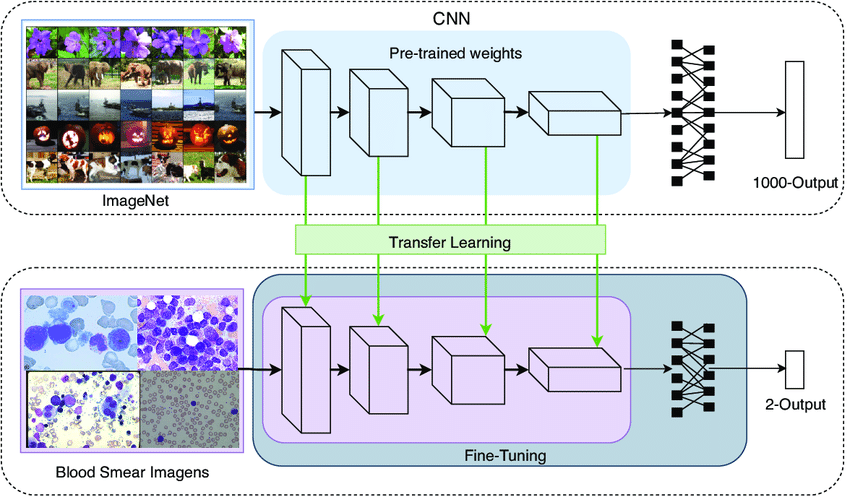


In [8]:
pre_trained_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
pre_trained_model.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
print(last_output)

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_18>


Adding new classifier and other layers as per requirement.

In [12]:
x = Flatten()(last_output)          #layer=layer()(previous layer)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(4,activation = 'softmax')(x)

model = Model(pre_trained_model.input,x)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,409,924 (154.15 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]

model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=metrics)

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
history = model.fit(train_generator,epochs=2,validation_data=validation_generator,batch_size=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 810ms/step - accuracy: 0.4966 - loss: 6.9190 - precision: 0.4969 - recall: 0.4716 - val_accuracy: 0.7600 - val_loss: 1.2126 - val_precision: 0.7677 - val_recall: 0.7600
Epoch 2/2
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7863 - loss: 0.7709 - precision: 0.7940 - recall: 0.7833 - val_accuracy: 0.7900 - val_loss: 0.7256 - val_precision: 0.7980 - val_recall: 0.7900


In [ ]:
!zip -r /content/my_folder.zip /content/Output/test


In [ ]:
from google.colab import files
files.download('my_folder.zip')

In [30]:
from zipfile import ZipFile
with ZipFile('/content/test.zip', 'r') as zipObj1:
   zipObj1.extractall('/content')

In [31]:
def calculate_test_preds(source,model):
  predictions = []
  for imgname in os.listdir(source):
    img_path = os.path.join('/content/test',imgname)
    img = image.load_img(img_path,target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = x/255.0

    pred = model.predict(x)
    pred = np.argmax(pred)
    predictions.append(pred)

  return predictions

In [ ]:
predictions = calculate_test_preds('/content/test',model)

In [39]:
true_labels = []
for filename in os.listdir('/content/test'):
  for cat in os.listdir('/content/MangoLeaf'):
    category = os.path.join('/content/MangoLeaf',cat)
    if filename in os.listdir(category):
      if cat == '1Partially Infected':
        true_labels.append(0)
      if cat == '2Quaterly':
        true_labels.append(1)
      if cat == '3Fully infected':
        true_labels.append(2)
      if cat == '4Healthy':
        true_labels.append(3)

In [40]:
print(classification_report(true_labels,predictions))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        52
           1       0.69      0.82      0.75        50
           2       0.71      0.45      0.56        22
           3       0.85      0.93      0.89        30

    accuracy                           0.79       154
   macro avg       0.78      0.75      0.76       154
weighted avg       0.79      0.79      0.78       154



In [41]:
cm=confusion_matrix(true_labels,predictions)
print(cm)

[[42  7  0  3]
 [ 4 41  4  1]
 [ 0 11 10  1]
 [ 2  0  0 28]]


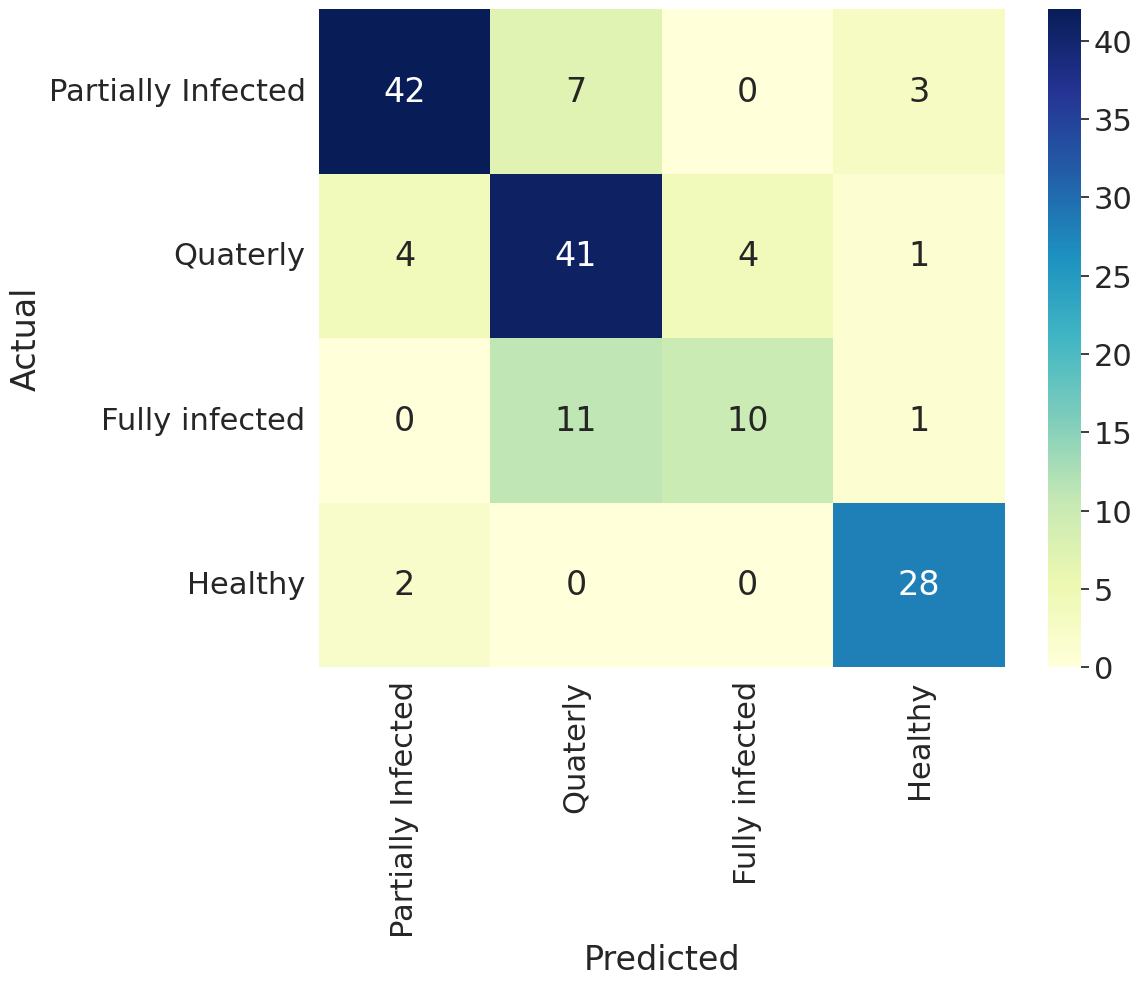

In [45]:
import seaborn
import numpy as np
seaborn.set(font_scale=2)
fig, ax = plt.subplots(figsize=(12,10))
classes = ['Partially Infected','Quaterly','Fully infected','Healthy']
seaborn.heatmap(cm, annot=True, fmt='d',xticklabels=classes, yticklabels=classes,cmap='YlGnBu')
bottom, top = ax.get_ylim()
'''ax.set_ylim(bottom + 0.5, top - 0.5)'''
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()